In [1]:
from keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.image import imread
from pylab import *
import math
import time
import decimal

### Inputs

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [3]:
X_train.shape #images, dimensions of each image, no 3rd dimension hence black and white image

(60000, 28, 28)

In [4]:
X_test.shape

(10000, 28, 28)

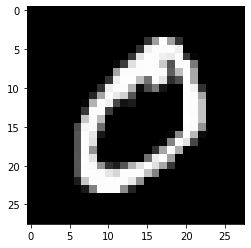

In [5]:
plt.imshow(X_train[1,:,:], cmap = 'gray')

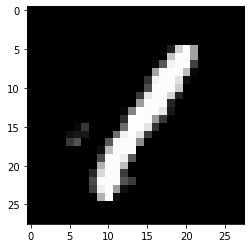

In [6]:
plt.imshow(X_train[201,:,:], cmap = 'gray')

### Preprocessing

In [7]:
X_train = X_train.reshape( ((28*28),60000) ) # to convert to 2d and NN format
X_train = X_train.astype('float32')/255 #Standardized

X_test = X_test.reshape( ((28*28),10000) )
X_test = X_test.astype('float32')/255
X_train.shape

(784, 60000)

In [8]:
Y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [9]:
nodes=[7,6,1]
act_functions = ['relu','relu','softmax']
X = X_train
Y = Y_train

### Layer Size

In [10]:
def layer_size(X, Y, nodes): #list of nodes does include nodes of output layer
    n_h = [X.shape[0]]
    for i in nodes:
        n_h.append(i)
    #n_h.append(Y.shape[0])
    return (n_h) # list of all nodes including n_x and n_y

In [11]:
n_h = layer_size(X, Y, nodes)
n_h

[784, 7, 6, 1]

### Parameters (W, b)

In [12]:
def int_value(n_h):
    np.random.seed(2)
    parameters = {}
    for i in range(1, len(n_h)):
        parameters['W' + str(i)] = np.random.randn(n_h[i], n_h[i-1]) *0.01 
        parameters['b' + str(i)] = np.zeros(shape = (n_h[i],1))
    return parameters

In [13]:
parameters = int_value(n_h)

### Activation functions and their Derivatives

In [14]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [15]:
def tanh(z):
    return np.tanh(z)

In [16]:
def relu(z):
    return np.maximum(0,z) #if z less than returns 0 or else return z

In [17]:
def leaky_relu(z):
    return np.maximum(0.01,z)

In [18]:
def softmax(z):
    return np.exp(z)/np.sum(np.exp(z))

In [19]:
def derivative(func, A):
    if func == 'sigmoid':
        return (A*(1-A))
    elif func == 'tanh' : 
        return (1 - np.power(A,2))
    elif func == 'relu' :
        return np.int64(A>0)
    elif func == 'leaky_relu' : 
        return np.int64(A>0.01)

### Forward Propogation

In [20]:
def fwd_prg(X, parameters, act_functions):
    cache = {}
    # Accesing functions name from the list of activation functions to be performed
    functions = {'sigmoid' : sigmoid, 'tanh' : tanh, 'relu' : relu, 'leaky_relu' : leaky_relu, 'softmax':softmax} 
    
    # Calculatiing Z1 and appending to dictionary
    cache['Z1'] = np.dot(parameters['W1'], X) + parameters['b1']
    # Calculating A1 and appending to dictionary
    cache['A1'] = functions[act_functions[0]](cache['Z1'])
    
    #Calculating and appending values of Z and A (Z2, A2, Z3, A3.....so on depending on your no. of hidden layers)
    for i in range(2, len(act_functions)+1):
        cache['Z' + str(i)] = np.dot( parameters['W' + str(i)], cache['A' + str(i-1)] ) + parameters['b' + str(i)]
        cache['A' + str(i)] = functions[act_functions[i-1]](cache['Z' + str(i)])
    return cache['A' + str(len(act_functions))], cache

In [21]:
A_op, cache =  fwd_prg(X, parameters, act_functions)

In [22]:
A_op.shape

(1, 60000)

In [23]:
X_train.shape,cache['A1'][0].shape

((784, 60000), (60000,))

### Viewing the hidden layers

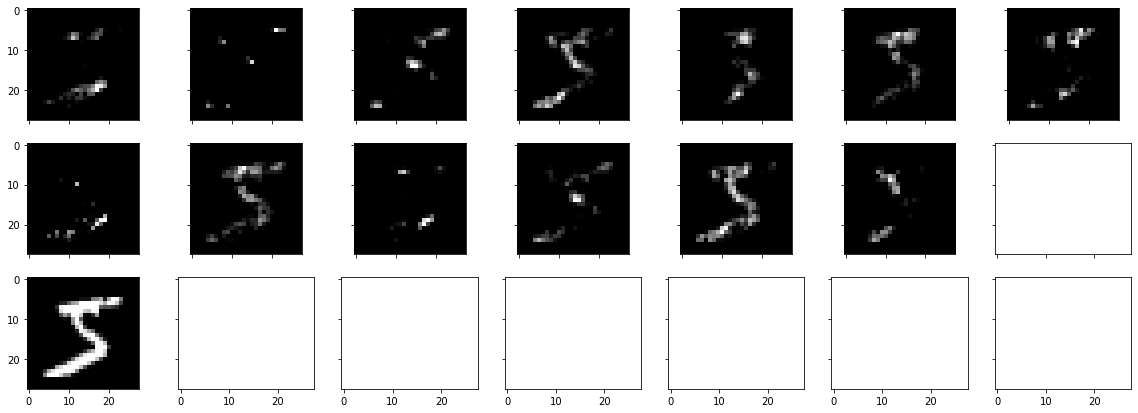

In [24]:
fig, ax = plt.subplots(len(nodes), max(nodes), sharex='col', sharey='row', figsize=(20,7))
for i in range(len(nodes)):
    for j in range(nodes[i]):
        z = X_train*cache['A' + str(i+1)][j]
        z = z.reshape(60000,28,28) # to convert to 3d for printing purposes
        ax[i,j].imshow(z[0,:,:], cmap = 'gray')

### Calculating Cost

In [25]:
def compute_cost(A_op, Y):
    m = Y.size
    cost = -np.sum( (Y*np.log(A_op)) + ((1-Y)*np.log(1-A_op)) ) / m
    return cost

### Backward Propogation

In [26]:
def bwd_prg(X, Y, parameters, cache, act_functions):
    m = Y.size
    grades = {}
    dZ_op = cache['A' + str(len(act_functions))] - Y
    
    for i in range(len(act_functions), 1, -1):
        grades['dW' + str(i)] = np.dot(dZ_op, cache['A' + str(i-1)].T)/m
        grades['db' + str(i)] = np.sum(dZ_op, axis = 1, keepdims = True)/m
        dA = np.dot(parameters['W' + str(i)].T, dZ_op)
        der = derivative( act_functions[i-2], cache['A'+str(i-1)] )
        dZ_op = np.multiply(dA, der)
         
    grades['dW1'] = np.dot(dZ_op, X.T)/m
    grades['db1'] = np.sum(dZ_op, axis = 1, keepdims = True)/m
        
    return grades 

### Update Parameters

In [27]:
def update(parameters, grades, alpha, layers):
    for i in range(1, layers+1):
        parameters['W' + str(i)] = parameters['W' + str(i)] - (alpha * grades['dW' + str(i)])
        parameters['b' + str(i)] = parameters['b' + str(i)] - (alpha * grades['db' + str(i)])
    return parameters

### Entire neural Network

In [28]:
def NN(X, Y, nodes, act_functions, alpha, epoch, print_cost):
    np.random.seed(2)
    n_h= layer_size(X, Y, nodes)
    parameters = int_value(n_h)
    past_cost = []
    
    for i in range(epoch):
        A_op, cache = fwd_prg(X, parameters, act_functions)
        
        cost = compute_cost(A_op, Y)
        past_cost.append(cost)
        
        grades = bwd_prg(X, Y, parameters, cache, act_functions)
        parameters = update(parameters, grades, alpha, len(act_functions))
        
        if print_cost and i%(epoch/10)==0: 
            print(cost)
    return parameters, past_cost

In [29]:
alpha = 0.001
epoch = 1000
print_cost = True

In [30]:
parameters, past_cost = NN(X, Y, nodes, act_functions, alpha, epoch, print_cost)

49.005927739611856
49.005927700425886
49.0059276797155
49.005927658720196
49.00592764444061
49.00592762906179
49.005927647150614
49.005927787072686
49.00592831813229
49.00592985266367


### Cost Graph

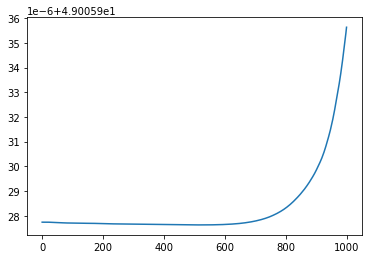

In [31]:
plt.plot(past_cost)
plt.show()